In [208]:
import numpy as np
from matplotlib import pyplot as plt
import robot_room as robot
import draw_hmm as hmm
from additive_histogram_filters_helper import get_exponential_distribution_symetric, \
        get_exponential_distribution, generate_sample, run_histogram_filter, plot_estimations,\
        get_walking_noise_example_1, get_walking_noise_example_2
from histogram_filters_helper import plot_distribution
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

## Generative Model - HMM

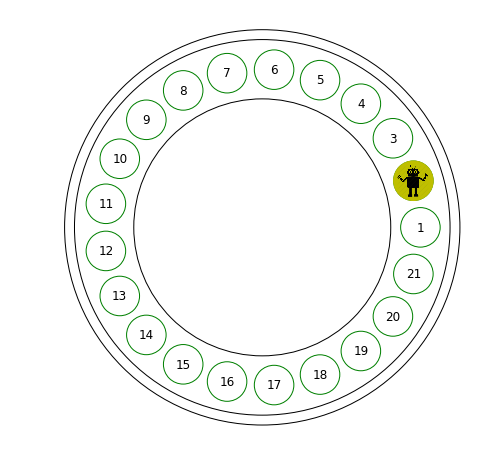

In [3]:
N = 21
robot.plot_robot_room(N = N, loc = 2)

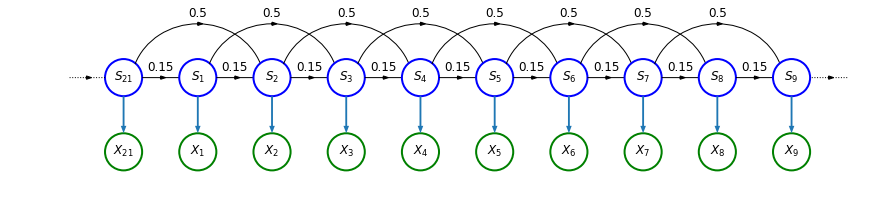

In [4]:
W = np.zeros(N)
W[0] = 0.15
W[1] = 0.50
W[2] = 0.35
pulse = np.array([0.2, 0.75, 0.9, 0.75, 0.2])
doors = np.array([4, 11, 26])
noise = 0.05
hmm.plot_basic_hmm_model(N = 21, N_states_visible = 10, circular = True, stay_step_prob=W[-1], 
                         one_step_prob= W[0], two_step_prob= W[1])

## The model
$S_k = S_{k-1} + 1 + W_n = S_{k-1} + W$

$X_k = S_k + V$

**Likelihood**: likelihood (Sensing distribution for a given state)

$P(X|S_k)$ 

**Prior** (belief): my belief before measuring

$P(S_k)$ 

**Posterior**: probability of a state given the measurements

$P(S_k|X)$

**Bayes**:

$P(S_k|X) = \frac{P(X|S_k)P(S_K)}{P(X)}$

$P(X) = \sum_i{P(X,S_i)} = \sum_i{P(X|S_i)P(S_i)}$

**Measurement error**:

$V$ 

**Walking noise**:

$P(W_n =-1) = 0.15$ (Stay)

$P(W_n=0) = 0.50$ (Move one)

$P(W_n=1) = 0.35$ (Move two)

## The goal: 
Estimate $S_k$ given all the observations $X_k$

## The observation $X = S_k + V$

In [5]:
# observation_func = get_exponential_distribution_symetric
observation_func = get_exponential_distribution

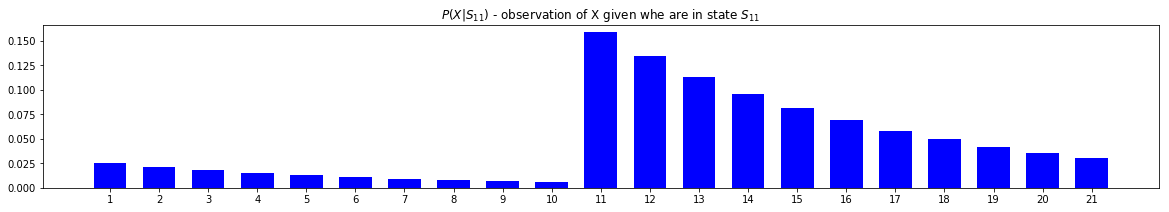

In [6]:
scale = 6
observation = observation_func(N= N, loc = int((N+1)/2), scale = scale)
plot_distribution(observation, title="$P(X|S_{11})$ - observation of X given whe are in state $S_{11}$")

## The likelihood $P(X|S_k)$

### Example of likelihood of $P(X=5|S_k)$ for asymetric signal

In [7]:
def mirror_signal(signal, center):
    return np.roll(np.roll(signal,-center+1)[::-1],center)

0.0

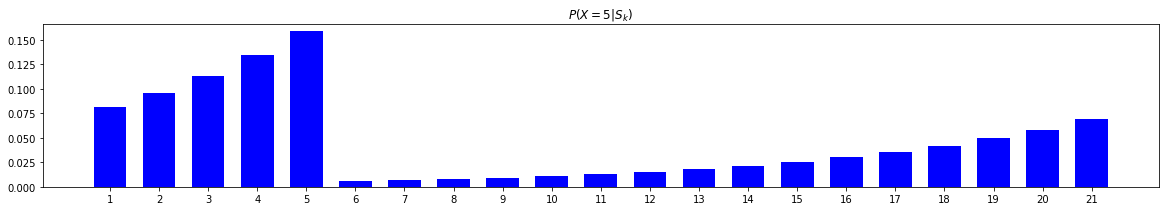

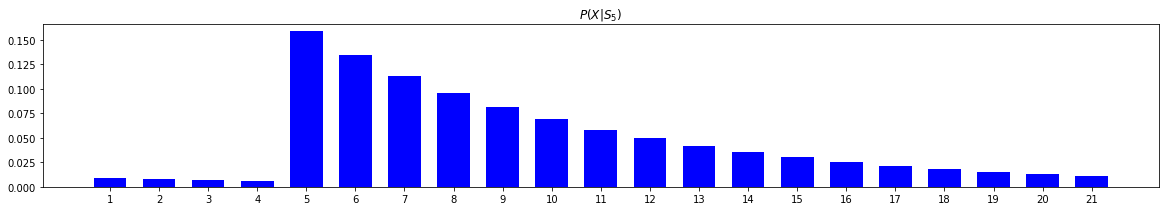

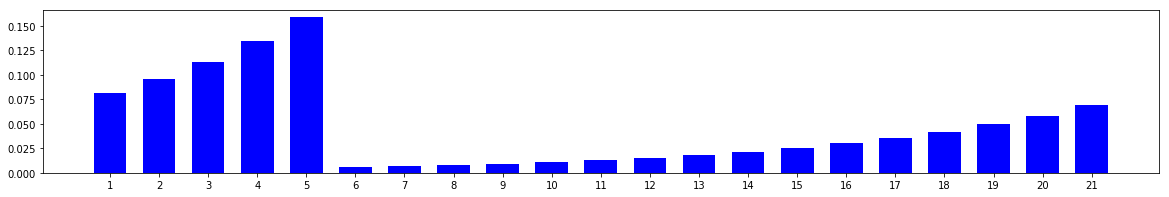

In [8]:
observation_func = get_exponential_distribution
likelihood = {}
X = 5
likelihood[5] = []
for k in range(N):
    likelihood_k = observation_func(N= N, loc = k+1, scale = scale)
    likelihood[5].append(likelihood_k[X-1])

plot_distribution(likelihood[5], title="$P(X=5|S_k)$")
observation_5 = observation_func(N= N, loc =5, scale = scale)
plot_distribution(observation_5, title="$P(X|S_5)$")
mirrored = mirror_signal(observation_5, X)
plot_distribution(mirrored)
(likelihood[5]-mirrored).sum()

### Get full likelihood

In [9]:
def get_likelihood(N, observation_func, scale = scale):
    likelihood = {}
    for X_0 in range(N):
        X = X_0 + 1
        likelihood[X] = []
        for k in range(N):
            likelihood_k = observation_func(N= N, loc = k+1, scale = scale)
            likelihood[X].append(likelihood_k[X-1])
    return likelihood

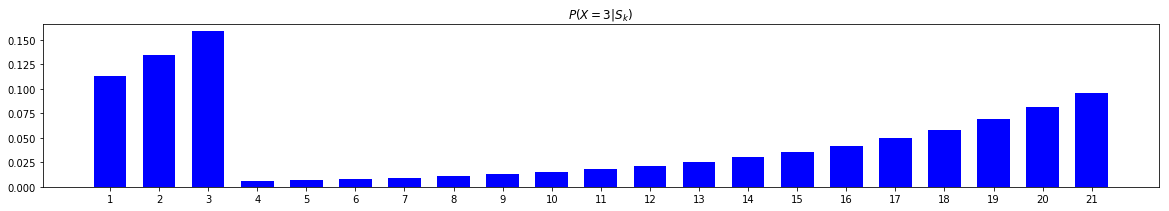

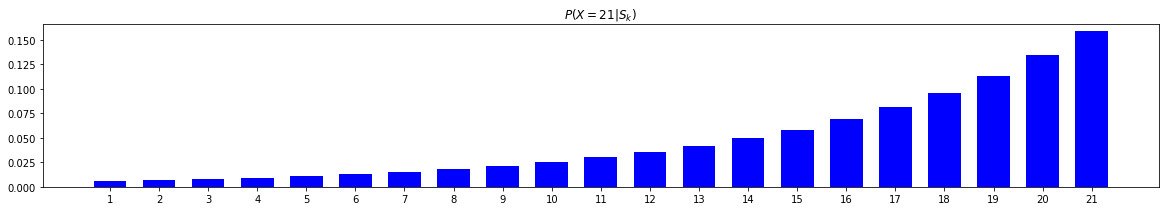

In [10]:
likelihood = get_likelihood(N, observation_func)
plot_distribution(likelihood[3], title="$P(X=3|S_k)$")
plot_distribution(likelihood[21], title="$P(X=21|S_k)$")

## The update -  $P(S_k|X) = \alpha P(X|S_k)P(S_K)$

In [11]:
def update(p, X, likelihood):
    # p: prior probability
    # X: Measurement. Measured position
    # posterior not normalized
    posterior = likelihood[X]*p
    # Normalize it
    normalized = posterior/posterior.sum()
    return normalized

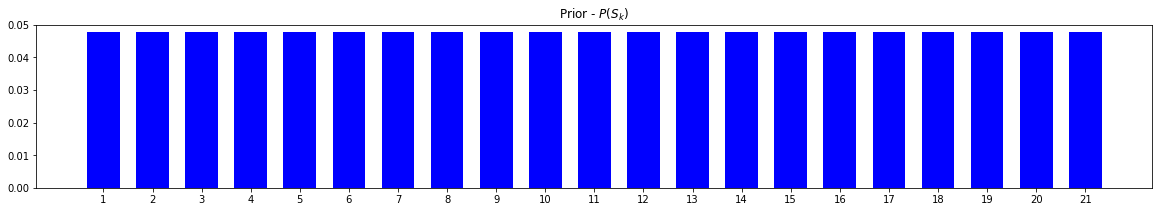

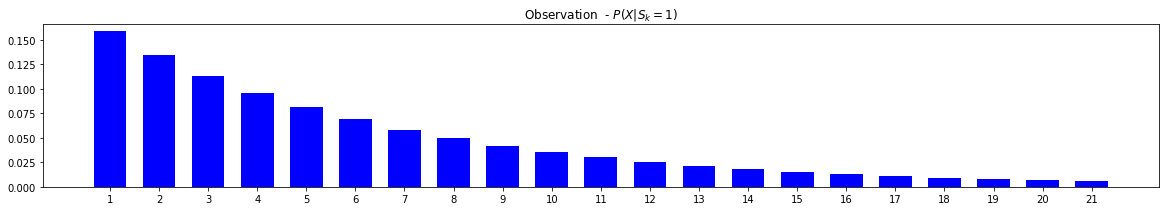

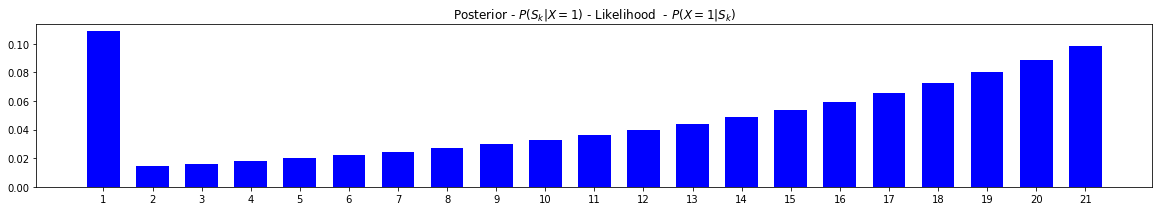

In [128]:
X = 1
p = np.ones(N)/N
posterior = update(p, X, likelihood)
plot_distribution(p, title="Prior - $P(S_k)$")
plot_distribution(observation_func(N= N, loc =X, scale = scale)
                  , title="Observation  - $P(X|S_k=%d)$"%X)
plot_distribution(posterior, title="Posterior - $P(S_k|X=%d)$"%X+" - Likelihood  - $P(X=%d|S_k)$"%X)

## The prediction - $S_{k-1} + W$
Whenever we want to find the distribution of the sum of 2 random variables we need to do the **convolution**

In [13]:
def convolve(x1, x2):
    conv = np.zeros(len(x1))
    for i in range(len(x2)):
        conv = conv + x2[i]*np.roll(x1,i)
    return conv

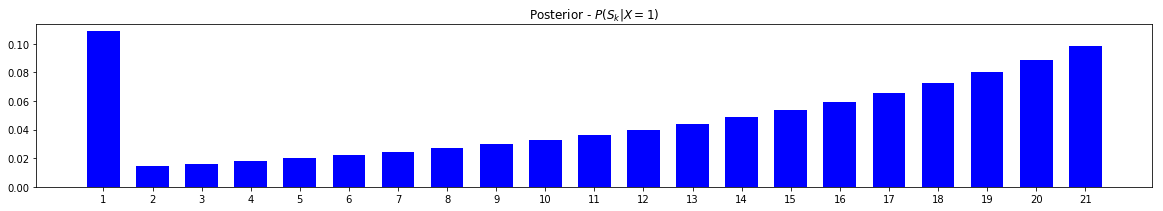

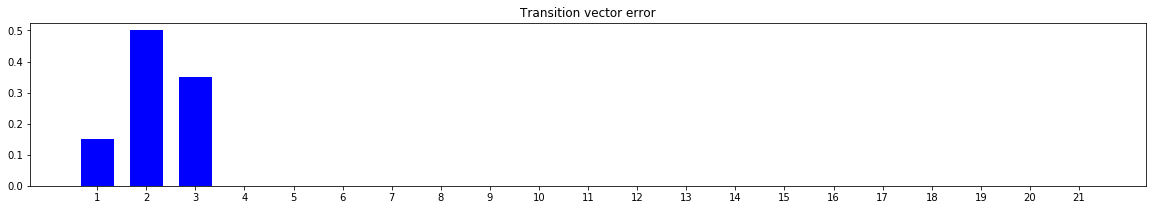

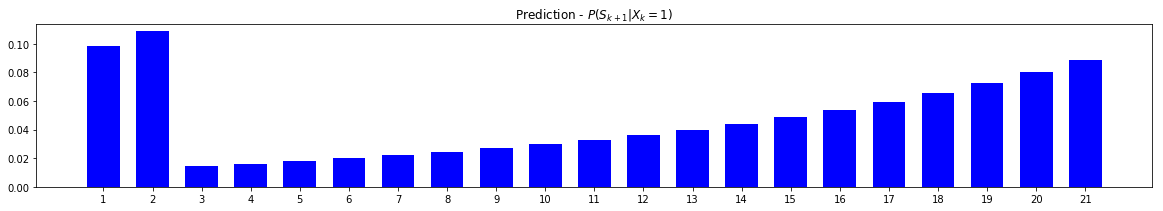

In [130]:
plot_distribution(posterior, title="Posterior - $P(S_k|X=%d)$"%X)
plot_distribution(W, title="Transition vector error")
prediction = convolve(posterior, Wpw)
plot_distribution(prediction, title="Prediction - $P(S_{k+1}|X_k=%d)$"%X)

## Generate Sample

Counter({3: 1200})


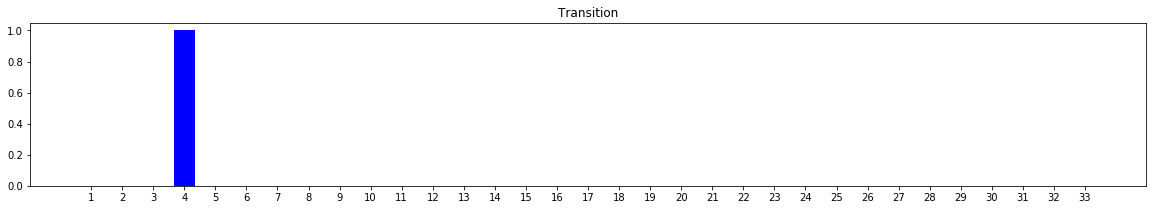

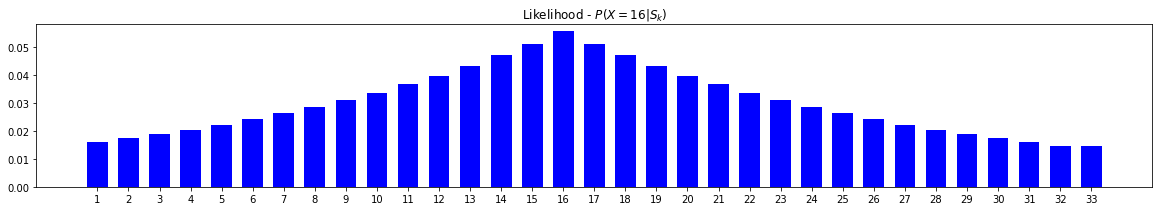

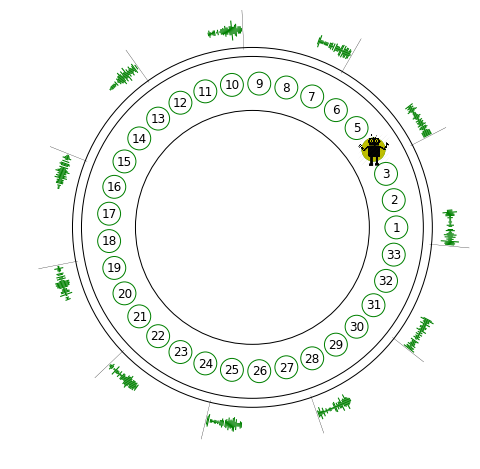

In [279]:
N = 33
steps = 1200
Wpw = np.zeros(N)
Wpw[3] = 1
#Wpw[2] = 0.5
Wo = get_walking_noise_example_2(N)
Wo = Wpw
plot_distribution(Wo, title="Transition")

observation_func = get_exponential_distribution_symetric
#observation_func = get_exponential_distribution
likelihood = get_likelihood(N, observation_func, scale=12)
X = int(N/2)
plot_distribution(likelihood[X], title="Likelihood - $P(X=%d|S_k)$"%X)

measurements, sample_stats, steps_stats, loc = generate_sample(likelihood, W=Wo, initial_state=1, steps = steps)
robot.plot_robot_room(N = N, loc = loc, sample_stats = sample_stats)

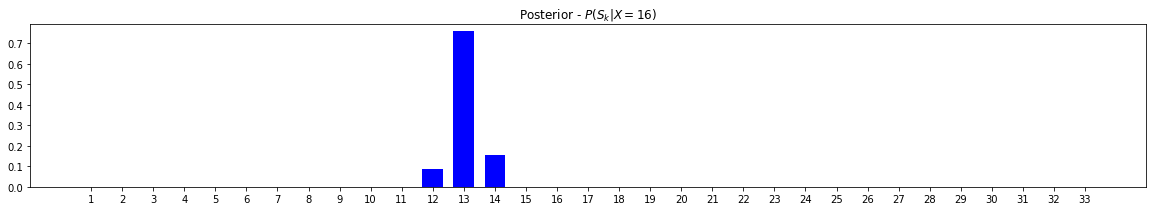

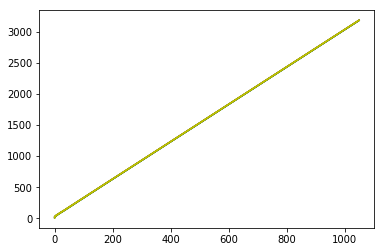

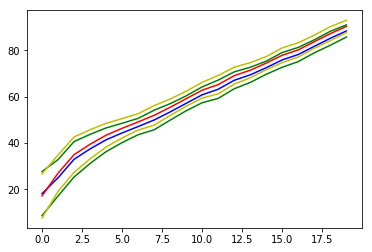

In [240]:
prior = np.ones(N)/N
posterior, mean_list, var_list, mean_list_pred, var_list_pred = run_histogram_filter(Wo, measurements, likelihood, prior)

plot_distribution(posterior, title="Posterior - $P(S_k|X=%d)$"%X)
plt.show()
plot_estimations(mean_list, var_list, mean_list_pred, var_list_pred, fr = 0)
plot_estimations(mean_list, var_list, mean_list_pred, var_list_pred, fr = 0, to = 20)